In [346]:
import numpy as np
import pandas as pd
import sys
from os.path import dirname
sys.path.append(dirname("../../src/"))

from parse_protein_symbols import entrez_dict
from process_labels.get_labels import get_go_labels

def get_labels(proteins,
               obofile,
               g2gofile,
               GOT = "F",
               min_level = 5,
               min_protein_annotation = 50,
               symbol_to_id = lambda x:x):
    """
    Get the protein GO labels corresponding to a given protein.
    """
    
    go_type = "molecular_function"
    go_type = "biological_process" if GOT=="P" else go_type
    go_type = "cellular_component" if GOT=="C" else go_type
    
    filter_protein = {"namespace": go_type, "lower_bound": min_protein_annotation}
    filter_labels  = {"namespace": go_type, "min_level": min_level}
    f_labels, labels_dict = get_go_labels(filter_protein,
                                          filter_labels,
                                          proteins,
                                          lambda x: x,
                                          g2gofile,
                                          obofile,
                                          verbose = True)
    
    return f_labels, labels_dict

## <span style="color:red">Get the HuRI human network and the proteins</span>

The annotated HuRi network is annotated with entrez Id.

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import networkx as nx

# HISTOGRAM
degrees_hist = {}

# huri_G       = nx.read_edgelist("../../data/HuRi.entrez.tsv")
# huri_C       = sorted(nx.connected_components(G), reverse = True, key = len)[0]
# huri_GC      = huri_G.subgraph(huri_C)
# nx.write_edgelist(huri_GC, "../../data/HuRi.connected.entrez.tsv")

huri_network = pd.read_csv("../../data/HuRi.connected.entrez.tsv", delim_whitespace = True, header = None)
huri_prots   = set(huri_network[0]).union(set(huri_network[1]))
huri_occurences = list(huri_network[0]) + list(huri_network[1])
huri_network = huri_network.drop([2], axis = 1)
huri_network

,0,1
0,64102,6676
1,64102,23786
2,64102,665
3,64102,945
4,64102,11148
...,...,...
52082,7360,7360
52083,80863,80863
52084,6120,6120
52085,27010,27010


In [348]:
_, deg       = zip(*(collections.Counter(huri_occurences)).items()) 
deg_count    = collections.Counter(deg)
degrees_hist = [("HURI-complete", k, deg_count[k]) for k in range(1000)]

## <span style="color:red">Get the STRING human network and the proteins</span>

The annotated STRING network is also annotated with entrez Id.

In [349]:
string_network = pd.read_csv("../../data/human.STRING.entrez.tsv", sep = "\t", header = None)
string_prots   = set(string_network[0]).union(set(string_network[1]))
string_occurences = list(string_network[0]) + list(string_network[1])

_, deg       = zip(*(collections.Counter(string_occurences)).items()) 
deg_count    = collections.Counter(deg)
degrees_hist+= [("STRING-complete", k, deg_count[k]) for k in range(1000)]

## <span style="color:red">Get the SUB-network constructed from the intersection of HuRI and STRING proteins</span>

| Desc.          | Freq.|
|--------------- |------|
|STRING proteins | 7365 |
|HuRI proteins   | 8224 |
|Intersection    | 3855 |

In [350]:
cprot = string_prots.intersection(huri_prots)
hsub  = ~(huri_network[0].isin(cprot) & huri_network[1].isin(cprot))
ssub  = ~(string_network[0].isin(cprot) & string_network[1].isin(cprot))

huri_net   = huri_network.drop(huri_network.index[hsub])
string_net = string_network.drop(string_network.index[ssub])


# Get Degree stats of the shared HURI and STRING network
huri_s_occur   = list(huri_net[0]) + list(huri_net[1])
string_s_occur = list(string_net[0]) + list(string_net[1])

## HURI
_, hdeg = zip(*(collections.Counter(huri_s_occur)).items())
_, sdeg = zip(*(collections.Counter(string_s_occur)).items())

hcount  = collections.Counter(hdeg)
scount  = collections.Counter(sdeg)
degrees_hist += [("STRING-shared", k, scount[k])  for k in range(1000)]
degrees_hist += [("HURI-shared", k, hcount[k])  for k in range(1000)]

deg_df = pd.DataFrame(degrees_hist, columns = ["Network", "deg", "frequency"])

(0.0, 10.0)

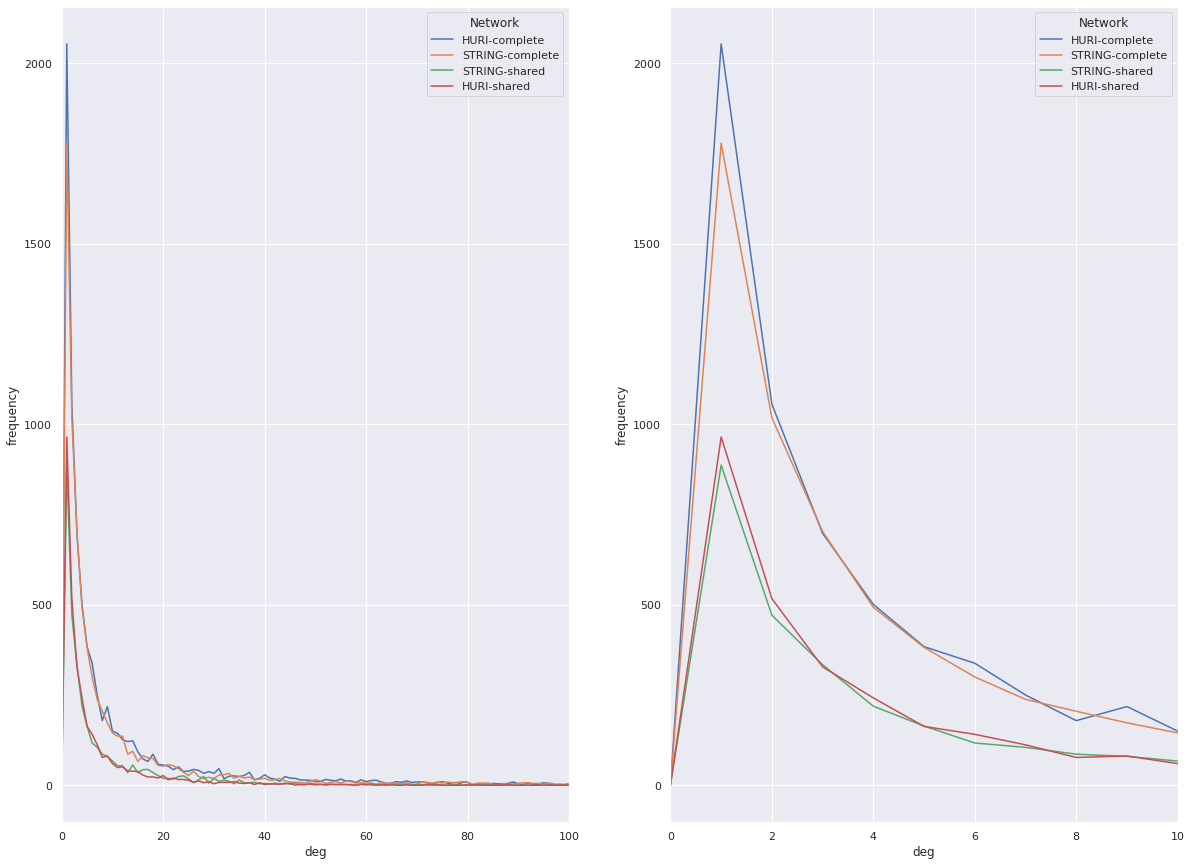

In [351]:
fig, [ax0, ax1] = plt.subplots(ncols=2)
sns.lineplot(data = deg_df, x = "deg", y = "frequency", hue="Network", ax=ax0)
ax0.set_xlim(0, 100)
sns.lineplot(data = deg_df, x = "deg", y = "frequency", hue="Network", ax=ax1)
ax1.set_xlim(0, 10)

# Analysis of the Link Prediction Scores 

In [352]:
def get_training_edges(G, training_perc = 0.75, test_neg_ratio = 20, k=5):
    training_edges = []
    test_edges     = []
    test_labels    = []
    mst            = nx.algorithms.tree.maximum_spanning_edges(G, 
                                                               algorithm="kruskal",
                                                              data = True)
    mst            = list(mst)
    R              = G.copy()
    R.remove_edges_from(mst)
    remaining      = R.edges(data = True)
    
    nodemap        = {i: k for i, k in enumerate(list(G.nodes()))}
    
    mst            = [(p, q, w[2]) for p, q, w in mst]
    remaining      = [(p, q, w[2]) for p, q, w in remaining]
    
    rem_n          = len(remaining)
    mst_n          = len(mst)
    
    remaining_r    = int(training_perc * (rem_n + mst_n) - mst_n)
    neg_count      = int(test_neg_ratio * (rem_n - remaining_r))
    print(f"Generating {k} Folds...")
    for i in range(k):
        print(f"\t{i}-th Fold...")
        ids = np.random.permutation(len(remaining))
        training_edges.append(mst + [remaining[i] for i in ids[:remaining_r]])
        
        test_edge  = [(remaining[i][0], remaining[i][1])  for i in ids[remaining_r:]]
        test_label = [1 for i in range(len(test_edge))]
                      
        tesposmap = {(p, q) for (p, q) in test_edge}
        n_testneg = 0
        neg_ids   = np.random.randint(len(nodemap), size=(neg_count+1000, 2))
        for i in range(neg_count + 1000):
            p_, q_ = neg_ids[i]
            if p_ == q_: 
                continue
            p      = nodemap[p_]
            q      = nodemap[q_]
            if (p, q) in tesposmap or (q, p) in tesposmap:
                continue
            n_testneg += 1
            test_edge.append((p, q))
            test_label.append(0)
            
            if n_testneg == neg_count:
                break
        test_edges.append(test_edge)
        test_labels.append(test_label)
        test_edge = None
    
    return training_edges, test_edges,  test_labels


In [353]:
huri_net[2]       = 1
string_net[2]     = 1
string_network[2] = 1
huri_network[2]   = 1

In [354]:
import networkx as nx
ss = nx.from_pandas_edgelist(string_net, 0, 1, 2)  # SHARED HURI
hs = nx.from_pandas_edgelist(huri_net, 0, 1, 2)     # SHARED HURI

# Had to do this for HuRi only. Works fine for STRING
hs_shared = sorted(nx.connected_components(hs), reverse = True, key = len)[0]
hs        = hs.subgraph(hs_shared)

sn = nx.from_pandas_edgelist(string_network, 0, 1, 2) # FULL STRING
hn = nx.from_pandas_edgelist(huri_network, 0, 1, 2) # FULL HURI

In [355]:
print("--STRING-S--")
ss_tr, ss_te, ss_label = get_training_edges(ss)
print("--HURI-S--")
hs_tr, hs_te, hs_label = get_training_edges(hs)
print("--STRING-H--")
sn_tr, sn_te, sn_label = get_training_edges(sn)
print("--HURI-H--")
hn_tr, hn_te, hn_label = get_training_edges(hn)

--STRING-S--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--HURI-S--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--STRING-H--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--HURI-H--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...


In [358]:
def compute_X_normalized(A, t = -1, lm = 1, is_normalized = True):
    n, _ = A.shape
    d    = A @ np.ones((n, 1))
    P    = A / d
    Identity = np.identity(A.shape[0])
    e = np.ones((A.shape[0], 1))

    D = np.diag(d.flatten())
    # Compute W
    scale = np.matmul(e.T, np.matmul(D, e))[0, 0]
    W = np.multiply(1 / scale, np.matmul(e, np.matmul(e.T, D)))

    up_P = np.multiply(lm, P - W)
    X_ = Identity - up_P
    X_i = np.linalg.pinv(X_)

    if t > 0:
        LP_t = Identity - np.linalg.matrix_power(up_P, t)
        X_i = np.matmul(X_i, LP_t)

    if is_normalized == False:
        return X_i

    # Normalize with steady state
    SS = np.sqrt(np.matmul(D, e))
    SS = 1 / SS
    SS = np.diag(SS.flatten())

    return np.matmul(X_i, SS)

def construct_neighbors_dict(training_graph):
    neighbors_dict = {}
    for p, q, _ in training_graph:
        for m, n in [(p, q), (q, p)]:
            neighbors_dict[m] = ([n] if m not in neighbors_dict 
                                 else neighbors_dict[m] + [n])
    return neighbors_dict

def construct_edge_dict(training_graph):
    edges = {}
    for p, q, w in training_graph:
        edges[(p, q)] = w
        edges[(q, p)] = w
    return edges

def predict_edges_cw(training_edges, test_pairs, neighbors_dict = None, edge_dict = None):
    if neighbors_dict == None:
        neighbors_dict = construct_neighbors_dict(training_edges)
    if edge_dict == None:
        edge_dict = construct_edge_dict(training_edges)
    
    scores = []
    for p, q in test_pairs:
        cw_score         = 0
        common_neighbors = set(neighbors_dict[p]).intersection(neighbors_dict[q])
        for n in common_neighbors:
            cw_score += edge_dict[p, n] + edge_dict[q, n]
        cw_score /= np.sqrt(len(neighbors_dict[p]) * len(neighbors_dict[q]))
        scores.append(cw_score)
    scores = np.array(scores) 
    return scores / np.max(scores)


def predict_edges_l3(training_edges, test_pairs, normalize = True):
    def construct_adj(edges):
        """
        Constructs two adjacency matrices: A and (A / (sqrt(d)) / sqrt(d).T
        """
        if len(edges[0]) == 2:
            node1, node2 = zip(*edges)
        else:
            node1, node2, _ = zip(*edges)
        nodeset = set(node1).union(set(node2))
        nodemap = {node: i for i, node in enumerate(nodeset)}
        n       = len(nodemap)
        A       = np.zeros((n, n))
        for ed in zip(node1, node2):
            p, q = list(map(lambda x: nodemap[x], ed))
            A[p, q] = 1
            A[q, p] = 1
        d_sq = np.sqrt(A @ np.ones((n, 1)))
        M    = (A / d_sq) / d_sq.T
        return A, M, nodemap
    A, M, nodemap = construct_adj(training_edges)
    scores        = np.zeros((len(test_pairs),))
    l3_scores     = A @ M @ A
    for i, (p_, q_) in enumerate(test_pairs):
        p, q = list(map(lambda x: nodemap[x], [p_, q_]))
        scores[i] = l3_scores[p, q]
    if normalize:
        return scores / np.max(scores)
    else:
        return scores

def predict_edges_glide(training_edges, test_pairs, normalized = True):
    l3_scores = predict_edges_l3(training_edges, test_pairs, normalize = False)
    dsd_scores = predict_edges_dsd(training_edges, test_pairs, normalized= True, return_normalized_score = False)
    alpha, beta, delta = 0.1, 1000, 0.01
    scores    = np.zeros((len(test_pairs), ))
    for i in range(len(test_pairs)):
        scores[i] = np.exp(alpha / (1 + beta / dsd_scores[i])) * l3_scores[i] + delta * dsd_scores[i]
    return scores / np.max(scores)

def predict_edges_dsd(training_edges, test_pairs, normalized = False, return_normalized_score = True):
    # Compute Embedding
    ps, qs, ws = zip(*training_edges)
    nodes      = set(ps).union(set(qs))
    nodemap    = {k: i for i, k in enumerate(nodes)}
    n          = len(nodemap)
    A          = np.zeros((n, n))
    for p, q, w in training_edges:
        A[nodemap[p], nodemap[q]] = w
        A[nodemap[q], nodemap[p]] = w 
    X = compute_X_normalized(A, t = -1, lm = 1, is_normalized = normalized)
    
    # Compute distance
    scores     = []
    for p_, q_ in test_pairs:
        p = nodemap[p_]
        q = nodemap[q_]
        dist = np.linalg.norm(X[p] - X[q])
        scores.append(1 / (dist + 0.00001))
    scores     = np.array(scores)
    if return_normalized_score:
        return scores / np.max(scores)
    else:
        return scores



In [359]:
i = 0
glidescores = predict_edges_glide(ss_tr[i], ss_te[i])
l3scores    = predict_edges_l3(ss_tr[i], ss_te[i])

ga = average_precision_score(ss_label[i], glidescores)
la = average_precision_score(ss_label[i], l3scores)
ga, la

(0.8156565243970424, 0.8064580873580284)

In [360]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
curves        = {}
table_results = [] # should be of the form (Dataset, Fold, Methodname, ScoreType, Value)

for tr, te, label, network in [(hs_tr, hs_te, hs_label, "HURI-SHARED"),
                                (hn_tr, hn_te, hn_label, "HURI-FULL"),
                                (ss_tr, ss_te, ss_label, "STRING-SHARED"),
                                (sn_tr, sn_te, sn_label, "STRING-FULL")]:
    print(f"Dataset: {network}...")
    for k in range(5):
        print(f"\tFold: {k}...")
        for method, mname in [(predict_edges_cw, "cw_normalized"),
                             (predict_edges_dsd, "dsd_unnormalized"),
                              (predict_edges_l3, "l3"),
                              (predict_edges_glide, "glide_l3")
                             ]:
            print(f"\t\tMethod: {mname}")
            
            scores = method(tr[k], te[k])
            aupr   = average_precision_score(label[k], scores)
            roc    = roc_auc_score(label[k], scores)
            table_results.append((network, k, mname, "AUPR", aupr))
            table_results.append((network, k, mname, "ROC", roc))
            
            # AUPR
            prec, recall, thresholds = precision_recall_curve(label[k], scores)
            curves[f"{network}:{mname}:{k}:PREC"]   = prec
            curves[f"{network}:{mname}:{k}:RECALL"] = recall
        # DSD-NORMALIZED
        mname  = "dsd_normalized"
        print(f"\t\tMethod: {mname}")     
        scores = method(tr[k], te[k], normalized = True)
        aupr   = average_precision_score(label[k], scores)
        roc    = roc_auc_score(label[k], scores)
        table_results.append((network, k, mname, "AUPR", aupr))
        table_results.append((network, k, mname, "ROC", roc))
            
        # AUPR
        prec, recall, thresholds = precision_recall_curve(label[k], scores)
        curves[f"{network}:{mname}:{k}:PREC"]   = prec
        curves[f"{network}:{mname}:{k}:RECALL"] = recall

Dataset: HURI-SHARED...
	Fold: 0...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 1...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 2...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 3...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 4...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
Dataset: HURI-FULL...
	Fold: 0...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 1...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_normalized
	Fold: 2...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: l3
		Method: glide_l3
		Method: dsd_norma

In [367]:
df_table = pd.DataFrame(table_results, columns = ["networks", "k-folds", "methods", "metric", "score"])
# df_table = pd.read_csv("link_prediction.tsv", sep = "\t")
df_table

,networks,k-folds,methods,metric,score
0,HURI-SHARED,0,cw_normalized,AUPR,0.149876
1,HURI-SHARED,0,cw_normalized,ROC,0.652248
2,HURI-SHARED,0,dsd_unnormalized,AUPR,0.342719
3,HURI-SHARED,0,dsd_unnormalized,ROC,0.871010
4,HURI-SHARED,0,l3,AUPR,0.551244
...,...,...,...,...,...
195,STRING-FULL,4,l3,ROC,0.964825
196,STRING-FULL,4,glide_l3,AUPR,0.867710
197,STRING-FULL,4,glide_l3,ROC,0.974160
198,STRING-FULL,4,dsd_normalized,AUPR,0.867710


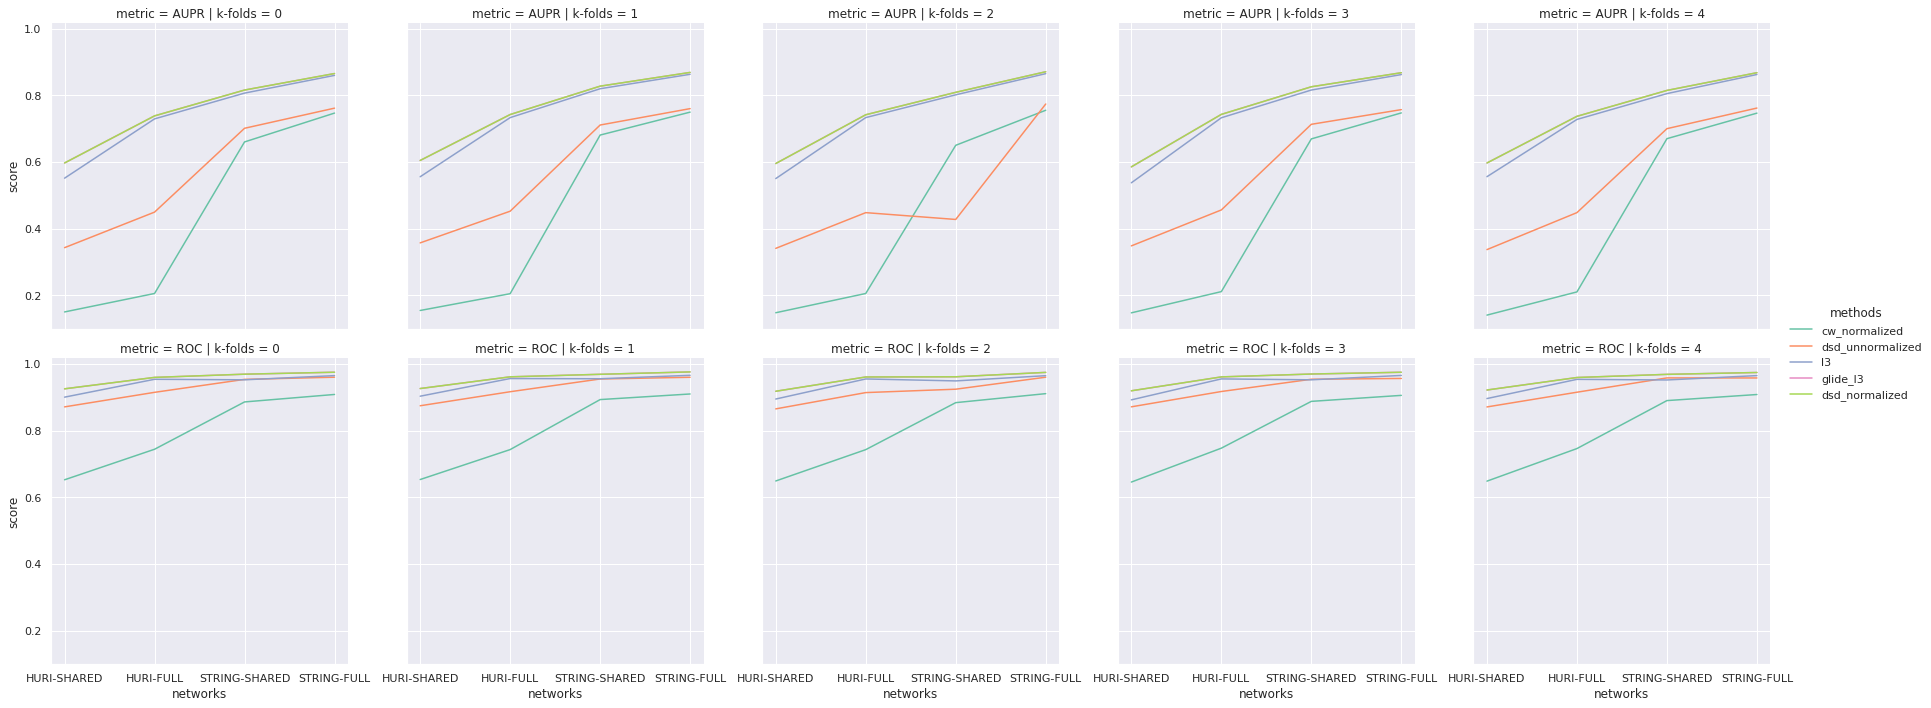

In [373]:
import seaborn as sns
sns.relplot(
    data = df_table,
    x="networks",
    y="score",
    col="k-folds",
    hue="methods",
    row="metric",
    kind = "line",
    sizes = (10, 100),
    palette="Set2"
)
#plt.savefig("link_prediction_results.png")
#df_table.to_csv("link_prediction.tsv", sep = "\t", index = False)

# LOOK for the number of 3-cliques, 4-cliques for all 4 NETWORKS. 
# NULL distribution: Motiff is similar to the Erdos Reyini 
# Triangle and 4 Cliques should be higher in STRING than HURI (shared)



In [374]:
def construct_adj(G):
    nodes = list(G.nodes())
    nodemap = {k: i for i, k in enumerate(nodes)}
    n     = len(nodes)
    A     = np.zeros((n, n))
    for p_, q_ in G.edges():
        p = nodemap[p_]
        q = nodemap[q_]
        A[p, q] = 1
        A[q, p] = 1
    return A, nodemap

# Spectral Clustering Results For the Shared HURI and STRING networks

In [269]:
import networkx as nx

ss_connected_comp = sorted(nx.connected_components(ss), reverse = True, key = len)[0]
ss                = ss.subgraph(ss_connected_comp)
A_s, map_s        = construct_adj(ss)
A_h, map_h        = construct_adj(hs)
# hs

In [270]:
## FuncAssociate
import http.client
import json
import ast
class FuncAssociate():
    host      = "llama.mshri.on.ca"
    query_url = "/cgi/funcassociate/serv"
    def __init__(self):
        self.conn = http.client.HTTPConnection(self.host)
        
    def jsonify(self, payload):
        return (json.dumps(payload)).encode('utf-8')
    
    def generate_payload(self, genelist):
        payload = {"id": "dc8bed03b5a9787447db75d7b948784f",
                  "method": "functionate",
                  "params": [
                      {
                          "query": list(genelist),
                          "species": "Homo sapiens",
                          "namespace": "entrezgene"
                      }
                  ],
                  "jsonrpc": "2.0"}
        return payload
    
    def request(self, list_of_entrezgene):
        payload = self.generate_payload(list_of_entrezgene)
        self.conn.request('POST', self.query_url, self.jsonify(payload), 
                       headers={'Content-type': 'application/json'})
        response = self.conn.getresponse()
        resdict  = json.loads(response.read().decode("UTF-8"))
        columns  = ["No-queries-having-row's-attribute", 
                    "len(queries)",
                    "Total-queries-having-row's-attribute",
                    "logarithm-odds-ratio",
                   "p-value",
                   "adjusted-p-value",
                   "Gene-Ontology-Id",
                   "Gene-Ontology-Attribute"]
        return pd.DataFrame(resdict["result"]["over"], columns = columns)


fassoc = FuncAssociate()

In [271]:
from sklearn.cluster import SpectralClustering

def recursive_clustering(A, clusters, lower, higher):
    indices_to_cluster = [list(range(A.shape[0]))]
    labels             = {}
    label_count        = 0
    while(True):
        
        # Break condition
        if len(indices_to_cluster) == 0:
            break
        
        ids   = indices_to_cluster.pop()
        Aid   = A[np.ix_(ids, ids)] 
        idmap = {i:k for i, k in enumerate(ids)}
        c_ss  = SpectralClustering(n_clusters = clusters, affinity="precomputed").fit(Aid)
        
        # labels - id mapping
        gen_labels = {}
        for i, label in enumerate(c_ss.labels_):
            gen_labels[label] = ([idmap[i]] if label not in gen_labels
                                 else gen_labels[label] + [idmap[i]])
        for l in gen_labels:
            if len(gen_labels[l]) < lower:
                pass
            elif len(gen_labels[l]) > higher:
                indices_to_cluster.append(gen_labels[l].copy())
            else:
                labels[label_count] = [k for k in gen_labels[l]]
                label_count        += 1
    return labels

## STRING clusters

In [272]:
# Cluster
c_ss = recursive_clustering(A_s, 3, 50, 500)

/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_e

In [273]:
from sklearn.manifold import TSNE
# Embedding
X_sn = compute_X_normalized(A_s)
T_sn = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(X_sn)

In [340]:
ids_to_select = []
for i in c_ss:
    ids_to_select += c_ss[i]
ids_to_select = sorted(ids_to_select)
ids_to_select

T_snfiltered = T_sn[ids_to_select]
idmap        = {i:k for i, k in enumerate(ids_to_select)}
ridmap       = {k:i for i, k in idmap.items()}
labels       = np.zeros((len(idmap),))

c_ss_entrez  = {}
r_map_s      = {k:i for i, k in map_s.items()}
for i in c_ss:
    c_ss_entrez[i] = []
    for j in c_ss[i]:
        labels[ridmap[j]] = i 
        c_ss_entrez[i].append(r_map_s[j])

In [341]:
ss_table = {}
ss_table["x"] = T_snfiltered[:, 0]
ss_table["y"] = T_snfiltered[:, 1]
ss_table["label"] = labels

df_ss = pd.DataFrame(ss_table)
df_ss

,x,y,label
0,-20.201647,44.925121,2.0
1,-22.015604,30.967426,2.0
2,-52.729824,-0.261148,2.0
3,-19.552481,45.189346,2.0
4,-18.107325,40.914078,2.0
...,...,...,...
2589,-12.280029,47.728500,2.0
2590,24.412138,34.690495,6.0
2591,-16.421650,23.802814,7.0
2592,4.889961,8.750048,4.0


In [279]:
fenrich_ss = {}
for label, prots in c_ss.items():
    print(f"Label: {label}")
    fenrich_ss[label] = fassoc.request(list(prots))

Label: 0
Label: 1
Label: 2
Label: 3
Label: 4
Label: 5
Label: 6
Label: 7
Label: 8
Label: 9
Label: 10


In [342]:
phat_thres = 0.0005
f_ss       = {}
for i in fenrich_ss:
    f_ss[i] = fenrich_ss[i].loc[fenrich_ss[i]["adjusted-p-value"] <= phat_thres]

In [344]:
df_ss["label"] = df_ss["label"].apply(lambda x: f"{int(x)} -"  + ( " No Enrichment " if f_ss[int(i)].empty else f_ss[int(x)].loc[f_ss[int(x)]["adjusted-p-value"].idxmin()]["Gene-Ontology-Attribute"]))

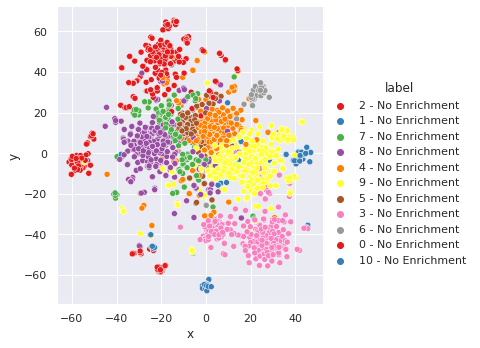

In [345]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.relplot(data=df_ss, x="x", y = "y", hue="label", palette="Set1")

# HURI clusters

In [375]:
from sklearn.cluster import SpectralClustering

# Cluster
c_hs = recursive_clustering(A_h, 3, 50, 500)

/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/afs/csail.mit.edu/u/k/kdevko01/miniconda3/envs/dscript/lib/python3.7/site-packages/sklearn/manifold/_spectral_e

In [376]:
from sklearn.manifold import TSNE
# Embedding
X_hn = compute_X_normalized(A_h)
T_hn = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(X_hn)

In [377]:
ids_to_select = []
for i in c_hs:
    ids_to_select += c_hs[i]
ids_to_select = sorted(ids_to_select)
ids_to_select

T_hnfiltered = T_hn[ids_to_select]
idmap        = {i:k for i, k in enumerate(ids_to_select)}
ridmap       = {k:i for i, k in idmap.items()}
labels       = np.zeros((len(idmap),))
c_hs_entrez  = {}
r_map_h      = {k:i for i, k in map_h.items()}

for i in c_hs:
    c_hs_entrez[i] = []
    for j in c_hs[i]:
        labels[ridmap[j]] = i 
        c_hs_entrez[i].append(r_map_h[j])

In [378]:
hs_table = {}
hs_table["x"] = T_hnfiltered[:, 0]
hs_table["y"] = T_hnfiltered[:, 1]
hs_table["label"] = labels

df_hs = pd.DataFrame(hs_table)
df_hs

,x,y,label
0,2.222839,-62.017620,11.0
1,-7.293729,-55.698833,11.0
2,-9.962173,-51.138676,11.0
3,-3.327819,-55.095383,11.0
4,-7.758874,-59.851665,11.0
...,...,...,...
2572,41.914711,5.627805,4.0
2573,47.255219,-6.503786,3.0
2574,21.947636,-18.923061,2.0
2575,24.533741,-11.071270,2.0


In [300]:
fenrich_hs = {}
for label, prots in c_hs.items():
    print(f"Label: {label}")
    fenrich_hs[label] = fassoc.request(list(prots))

Label: 0
Label: 1
Label: 2
Label: 3
Label: 4
Label: 5
Label: 6
Label: 7
Label: 8
Label: 9
Label: 10
Label: 11


In [379]:
fenrich_hs[0]

,No-queries-having-row's-attribute,len(queries),Total-queries-having-row's-attribute,logarithm-odds-ratio,p-value,adjusted-p-value,Gene-Ontology-Id,Gene-Ontology-Attribute
0,3,50,7,2.475437,6.661285e-07,0.002,GO:0016713,"oxidoreductase activity, acting on paired dono..."
1,4,50,17,2.116486,1.141995e-07,0.002,GO:0008395,steroid hydroxylase activity
2,5,50,31,1.919856,1.994488e-08,0.000,GO:0016709,"oxidoreductase activity, acting on paired dono..."
3,9,50,88,1.718795,1.923706e-12,0.000,GO:0004497,monooxygenase activity
4,4,50,45,1.628105,6.758005e-06,0.009,GO:0050661,NADP binding
5,4,50,46,1.617740,7.386762e-06,0.024,GO:0019825,oxygen binding
6,9,50,137,1.509086,1.092201e-10,0.000,GO:0016705,"oxidoreductase activity, acting on paired dono..."
7,5,50,86,1.430632,3.652091e-06,0.005,GO:0005581,collagen trimer
8,7,50,125,1.421407,4.578133e-08,0.000,GO:0020037,heme binding
9,7,50,135,1.385983,7.785513e-08,0.001,GO:0046906,tetrapyrrole binding


In [334]:
phat_thres = 0.0005
f_hs       = {}
for i in fenrich_hs:
    f_hs[i] = fenrich_hs[i].loc[fenrich_hs[i]["adjusted-p-value"] <= phat_thres]

In [335]:
df_hs["label"] = df_hs["label"].apply(lambda x: f"{int(x)} - " + ("No enrichment" 
                                                                  if f_hs[int(x)].empty else 
                                                                  ",".join(f_hs[int(x)].loc[f_hs[int(x)]["adjusted-p-value"].idxmin()]["Gene-Ontology-Attribute"].split(",")[:2]
                                                                          )
                                                                 )
                                     )

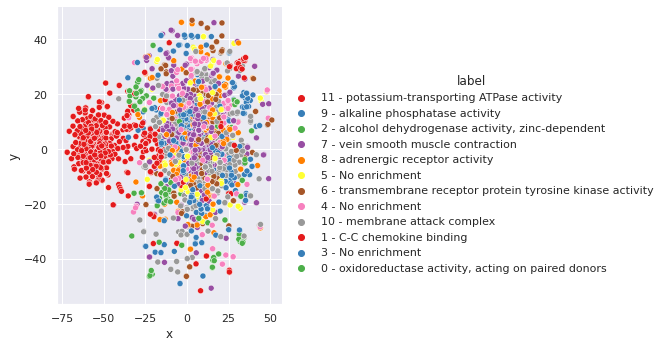

In [336]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.relplot(data=df_hs, x="x", y = "y", hue="label", palette="Set1")

In [1]:
from IPython.display import IFrame

IFrame(src='http://llama.mshri.on.ca/funcassociate/', width=700, height=600)

## Function Prediction